## Assignment Information

| Field | Details |
|-------|---------|
| **Name** | Pros Loung |
| **Course** | AAI-521 Applied Computer Vision for AI |
| **Assignment** | 3.1 - Object Detection and Segmentation |
| **GitHub Repository** | https://github.com/ploung/AAI-521-ComputerVision_Module3.git |

---

### Assignment Overview


In [6]:
# Import necessary libraries
# ! Install tensorflow-datasets if not already installed * *
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pylab as plt
import numpy as np
import cv2

In [9]:
#a) Load the oxford_iiit_pet dataset
# ! Load the latest version 4.*.* of the dataset
dataset, info = tfds.load('oxford_iiit_pet:4.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Loung\tensorflow_datasets\oxford_iiit_pet\incomplete.S539XZ_4.0.0\oxford_iiit_pet-train.tfr…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\Loung\tensorflow_datasets\oxford_iiit_pet\incomplete.S539XZ_4.0.0\oxford_iiit_pet-test.tfre…

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\Loung\tensorflow_datasets\oxford_iiit_pet\4.0.0. Subsequent calls will reuse this data.


In [36]:
# Explore the dataset

print("=" * 80)
print('Dataset information:', info)
print("=" * 80)


print('Dataset keys:', list(dataset.keys()))
print('Number of training samples:', info.splits['train'].num_examples)
print('Number of test samples:', info.splits['test'].num_examples)
print("Number of classes:", info.features['label'].num_classes)
print("Class names:", info.features['label'].names)

Dataset information: tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/4.0.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed and
    species. Additionally, head bounding boxes are provided for the training split,
    allowing using this dataset for simple object detection tasks. In the test
    split, the bounding boxes are empty.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='C:\\Users\\Loung\\tensorflow_datasets\\oxford_iiit_pet\\4.0.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=773.68 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'head_bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtyp

Training Dataset Samples:
Displaying 3: images


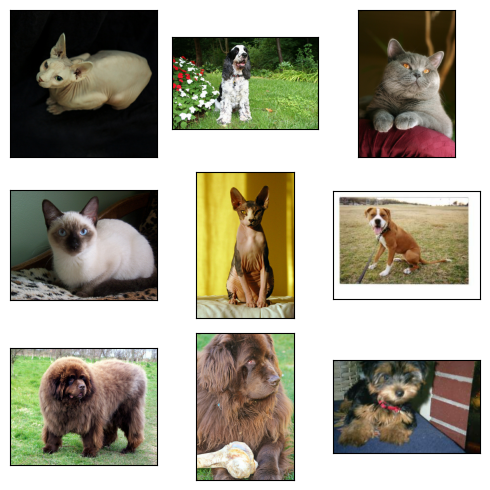

Testing Dataset Samples:
Displaying 3: images


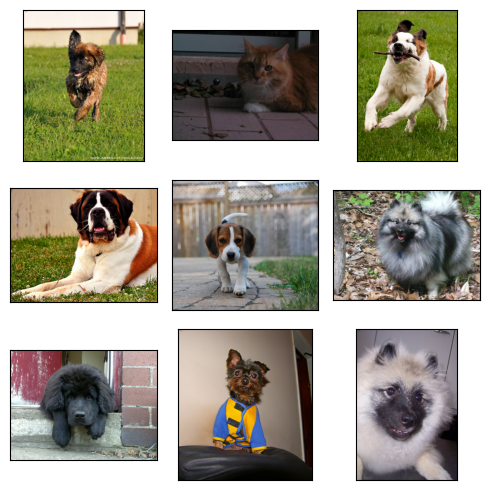

In [49]:
# Visualize some samples from the dataset 
ImageLabel = info.features['label'].names

def ShowImage(ImageData, NumImg=2):
    '''Displays the first number of images from the dataset.'''
    print(f'Displaying {NumImg}: images')
    plt.figure(figsize=(5, 5))
    for i in range(NumImg * NumImg):
        plt.subplot(NumImg, NumImg, i + 1)
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        plt.imshow(ImageData[i], cmap=plt.cm.binary)
        #plt.xlabel([ImageLabel[i]])
    plt.tight_layout()
    plt.show()

train_dataset = dataset['train']
test_dataset = dataset['test']

print("Training Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in train_dataset.take(9)], NumImg=3)

print("Testing Dataset Samples:")
ShowImage([data['image'].numpy().squeeze() for data in test_dataset.take(9)], NumImg=3)

In [ ]:
def read_and_preprocess(data):
    input_image = data['image']  # Use 'image' instead of 'train'
    input_mask = data['segmentation_mask']
    
    # Resize images to 128x128
    input_image = tf.image.resize(input_image, [128, 128])
    input_mask = tf.image.resize(input_mask, [128, 128])
    
    # ! Important: Proper image normalization for display
    input_image = tf.cast(input_image, tf.float32) / 255.0  # Normalize to [0,1]
    
    # ? Process mask properly
    input_mask = tf.cast(input_mask, tf.float32)
    input_mask -= 1  # {1,2,3} to {0,1,2}
    
    return input_image, input_mask

In [94]:
train = dataset['train'].map(read_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test = dataset['test'].map(read_and_preprocess)


Sample preprocessed images and their segmentation masks:


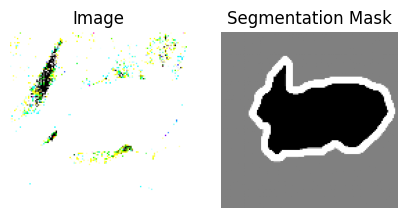

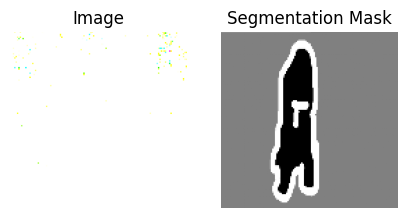

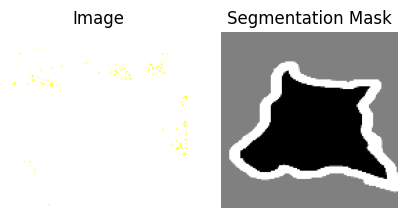

In [ ]:
print("Sample preprocessed images and their segmentation masks:")
for image, mask in train.take(3):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Image")
    # ! Important: Normalize image for proper display
    display_image = tf.clip_by_value(image, 0.0, 1.0)
    plt.imshow(display_image)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Segmentation Mask")
    # * Display mask with proper normalization
    display_mask = tf.squeeze(mask[:, :, 0])  # Remove channel dimension if present
    plt.imshow(display_mask, cmap='viridis')  # Use viridis for better visualization
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

**Part 2- Annotation**

In [ ]:
# Install mrcnn

In [ ]:
# Get data from here https://github.com/experiencor/raccoon_dataset


fatal: destination path 'raccoon_dataset' already exists and is not an empty directory.


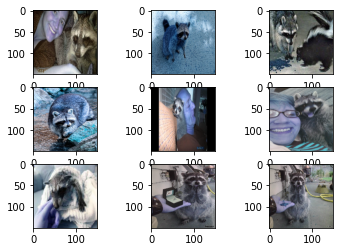

In [ ]:
# Look into data
# Plot some samples here


In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset

# class that defines and loads the raccoon dataset
class RaccoonDataset(Dataset):
	# load the dataset definitions
	def load_dataset(self, dataset_dir, is_train=True):
		# define one class
		self.add_class("raccoon_dataset", 1, "raccoon")
		# define data locations
		images_dir = dataset_dir + '/images/'
		annotations_dir = dataset_dir + '/annotations/raccoon-'
		# find all images
		for filename in listdir(images_dir):
			# extract image id
			image_id = filename[8:-4]
			# skip bad images
			if image_id in ['00090']:
				continue
			# skip all images after 150 if we are building the train set
			if is_train and int(image_id) >= 150:
				continue
			# skip all images before 150 if we are building the test/val set
			if not is_train and int(image_id) < 150:
				continue
			img_path = images_dir + filename
			ann_path = annotations_dir + image_id + '.xml'
			# add to dataset
			self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

	# extract bounding boxes from an annotation file
	def extract_boxes(self, filename):
		# load and parse the file
		tree = ElementTree.parse(filename)
		# get the root of the document
		root = tree.getroot()
		# extract each bounding box
		boxes = list()
		for box in root.findall('.//bndbox'):
			xmin = int(box.find('xmin').text)
			ymin = int(box.find('ymin').text)
			xmax = int(box.find('xmax').text)
			ymax = int(box.find('ymax').text)
			coors = [xmin, ymin, xmax, ymax]
			boxes.append(coors)
		# extract image dimensions
		width = int(root.find('.//size/width').text)
		height = int(root.find('.//size/height').text)
		return boxes, width, height

	# load the masks for an image
	def load_mask(self, image_id):
		# get details of image
		info = self.image_info[image_id]
		# define box file location
		path = info['annotation']
		# load XML
		#path = '/content/raccoon_dataset/annotations/raccoon-'+image_id   #Added by me
		boxes, w, h = self.extract_boxes(path)
		# create one array for all masks, each on a different channel
		masks = zeros([h, w, len(boxes)], dtype='uint8')
		# create masks
		class_ids = list()
		for i in range(len(boxes)):
			box = boxes[i]
			row_s, row_e = box[1], box[3]
			col_s, col_e = box[0], box[2]
			masks[row_s:row_e, col_s:col_e, i] = 1
			class_ids.append(self.class_names.index('raccoon'))
		return masks, asarray(class_ids, dtype='int32')

	# load an image reference
	def image_reference(self, image_id):
		info = self.image_info[image_id]
		return info['path']

# train set
train_set = RaccoonDataset()
train_set.load_dataset('raccoon_dataset', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

# test/val set
test_set = RaccoonDataset()
test_set.load_dataset('raccoon_dataset', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 149
Test: 51


In [ ]:
# load an image
# Use the function above to create the image and its mask

**Part 3- YOLO**




You can see how YOLO has been improved in the last few versions on COCO: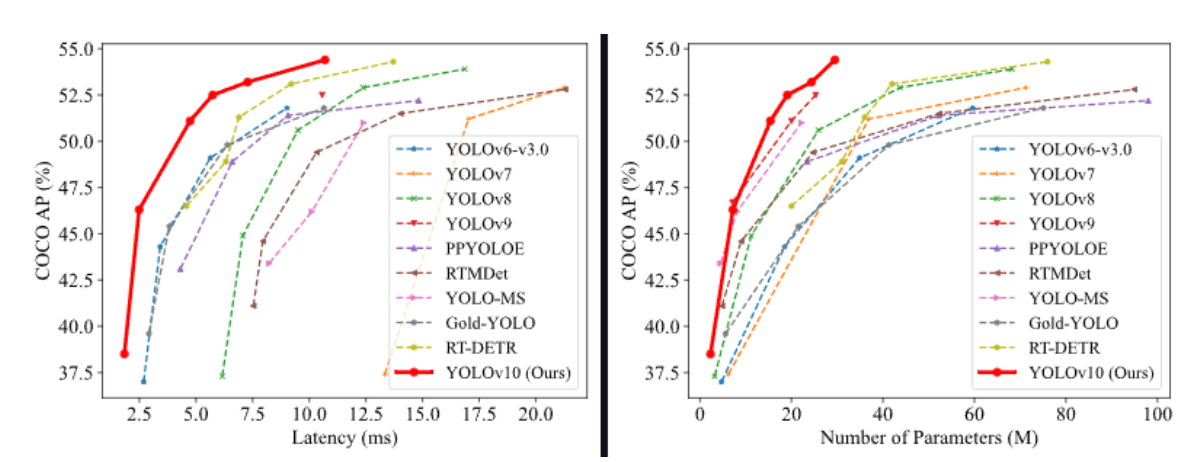

In [ ]:
# a- Create annotation
# You can upload the file using ![title](filename.jpeg)
# import image module



In [ ]:
#b- Download required tools
# Install the required packages.
import os
HOME = os.getcwd()
!pip install -q git+https://github.com/THU-MIG/yolov10.git

In [ ]:
# Load pretrained weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

In [ ]:
#c- Test the model out of box


In [ ]:
#d- Fine-tune the model
# Show the learning curve and confusion matrix


In [ ]:
# e- SExplain what you see in the learning curves and confusion matrix.